In [1]:
# !pip install numpy pandas scikit-learn torch torchvision torchaudio matplotlib tqdm --quiet

import os, re, glob, math, gc, warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ========= USER CONFIG =========
BASE = r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling"
TRAIN_CUTTERS = ["c1", "c4", "c6"]   # labeled
TEST_CUTTERS  = ["c2", "c3", "c5"]   # unlabeled

# Feature windows (change here to tune)
WIN = 4096          # samples per window  (≈82 ms @ 50 kHz)
HOP = 2048          # hop (overlap → better accuracy; 4096 = no overlap)
MAX_WINDOWS = 96    # truncate/pad time steps per cut (increase -> more context)

# Model / training
HIDDEN = 256        # LSTM hidden size (128–512 work well)
DROPOUT = 0.2
LR = 1e-3
EPOCHS = 35
LAMBDA_MONO = 0.3   # strength of monotonic penalty
MTL_WEIGHTS = (0.2, 0.2, 0.2, 1.0, 1.2)  # (f1,f2,f3,wear,RUL)
BATCH_SIZE = 8
VAL_RATIO = 0.15
SEED = 42
# ===============================

torch.manual_seed(SEED); np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
def read_wear_table(cutter_dir):
    # find wear csv
    cands = [p for p in glob.glob(os.path.join(cutter_dir, "*.csv"))
             if "wear" in os.path.basename(p).lower()]
    if not cands:
        raise FileNotFoundError(f"No wear csv in {cutter_dir}")
    wear_file = cands[0]

    # detect header
    raw0 = pd.read_csv(wear_file, sep=None, engine="python", nrows=5)
    try:
        v = pd.to_numeric(raw0.iloc[0,0], errors="coerce")
        use_header = bool(pd.isna(v))
    except Exception:
        use_header = True

    raw = (pd.read_csv(wear_file, sep=None, engine="python")
           if use_header else
           pd.read_csv(wear_file, sep=None, engine="python", header=None))
    raw.columns = [str(c).strip().lower() for c in raw.columns]

    def first_present(names):
        for n in names:
            if n in raw.columns: return n
        return None

    cut_col = first_present(["cut","cut_number","cut no","cut_no","c","index","id","0"])
    f1_col  = first_present(["flute_1","flute1","f1","flute 1","1"])
    f2_col  = first_present(["flute_2","flute2","f2","flute 2","2"])
    f3_col  = first_present(["flute_3","flute3","f3","flute 3","3"])

    if cut_col is None or f1_col is None or f2_col is None or f3_col is None:
        tmp = raw.copy().dropna(axis=1, how="all")
        assert tmp.shape[1] >= 4, "Wear file must have >=4 usable columns"
        tmp.columns = [f"col_{i}" for i in range(tmp.shape[1])]
        cut_col, f1_col, f2_col, f3_col = "col_0","col_1","col_2","col_3"
        raw = tmp

    cut_series = raw[cut_col].astype(str).str.extract(r"(\d+)", expand=False)
    cut_series = pd.to_numeric(cut_series, errors="coerce")

    f1 = pd.to_numeric(raw[f1_col], errors="coerce")
    f2 = pd.to_numeric(raw[f2_col], errors="coerce")
    f3 = pd.to_numeric(raw[f3_col], errors="coerce")

    df = pd.DataFrame({
        "Cut_Number": cut_series,
        "flute_1": f1, "flute_2": f2, "flute_3": f3
    }).dropna()
    df["Cut_Number"] = df["Cut_Number"].round().astype(int)

    # tool-level wear & per-cutter EOL
    df["wear_max"] = df[["flute_1","flute_2","flute_3"]].max(axis=1)
    EOL = float(df["wear_max"].max())

    # normalized targets [0,1]
    eps = 1e-9
    df["f1_norm"] = df["flute_1"] / (EOL + eps)
    df["f2_norm"] = df["flute_2"] / (EOL + eps)
    df["f3_norm"] = df["flute_3"] / (EOL + eps)
    df["wear_norm"] = df["wear_max"] / (EOL + eps)
    df["rul_norm"]  = 1.0 - df["wear_norm"]

    # raw RUL for metrics
    df["RUL"] = EOL - df["wear_max"]

    return df.sort_values("Cut_Number").reset_index(drop=True), EOL


def discover_cut_files(cutter_dir, cutter_id):
    all_csvs = glob.glob(os.path.join(cutter_dir, "**", "*.csv"), recursive=True)
    all_csvs = [p for p in all_csvs if "wear" not in os.path.basename(p).lower()]
    cuts = {}
    for p in all_csvs:
        name = os.path.basename(p).lower()
        m = re.search(rf"c[_-]?{cutter_id}[_-]?(\d+)\.csv$", name) or re.search(r"(\d+)\.csv$", name)
        if m:
            cuts[int(m.group(1))] = p
    return dict(sorted(cuts.items()))


In [3]:
def window_feats_1d(x):
    if x.size == 0:
        return np.zeros(7, dtype=np.float32)
    mean = x.mean()
    std  = x.std()
    rms  = float(np.sqrt(np.mean(x**2))) if x.size else 0.0
    mx   = float(x.max()) if x.size else 0.0
    crest = mx / (rms + 1e-9)

    X = np.fft.rfft(x, n=len(x))
    P = (np.abs(X)**2)
    power = float(P.sum())
    if power < 1e-12:
        centroid = 0.0
    else:
        freqs = np.fft.rfftfreq(len(x), d=1.0/50000.0)  # Fs=50 kHz
        centroid = float((freqs * P).sum() / power)

    return np.array([mean, std, rms, mx, power, centroid, crest], dtype=np.float32)

def extract_cut_windows(path):
    try:
        df = pd.read_csv(path, header=None, engine="c", low_memory=False)
    except Exception:
        df = pd.read_csv(path, header=None, engine="python", low_memory=False)
    df = df.dropna(axis=1, how="all")
    if df.shape[1] < 7:
        return None

    arr = df.iloc[:, :7].to_numpy(dtype=np.float32, copy=False)
    N = arr.shape[0]
    feats = []

    if N >= WIN:
        for start in range(0, N - WIN + 1, HOP):
            seg = arr[start:start+WIN, :]
            fwin = [window_feats_1d(seg[:, ch]) for ch in range(7)]
            feats.append(np.concatenate(fwin, axis=0))  # 7ch * 7feat = 49
            if len(feats) >= MAX_WINDOWS: break
    else:
        seg = arr
        fwin = [window_feats_1d(seg[:, ch]) for ch in range(7)]
        feats.append(np.concatenate(fwin, axis=0))

    F = np.stack(feats, axis=0)      # [T,49], T>=1
    T = F.shape[0]
    if T < MAX_WINDOWS:
        pad = np.zeros((MAX_WINDOWS - T, F.shape[1]), dtype=np.float32)
        F = np.concatenate([F, pad], axis=0)
    else:
        F = F[:MAX_WINDOWS]; T = MAX_WINDOWS
    return F, T


In [4]:
def build_index_for_cutters(cutters, labeled=True):
    index = []
    eol_map = {}
    for cname in cutters:
        cutter_dir = os.path.join(BASE, cname)
        cutter_id = int(re.findall(r"\d+", cname)[0])
        cut_files = discover_cut_files(cutter_dir, cutter_id)

        if labeled:
            wear_df, EOL = read_wear_table(cutter_dir)
            eol_map[cname] = EOL
            present = sorted(set(wear_df["Cut_Number"].astype(int)).intersection(cut_files.keys()))
            for cutn in present:
                row = wear_df.loc[wear_df["Cut_Number"]==cutn].iloc[0]
                y_norm = np.array([row["f1_norm"], row["f2_norm"], row["f3_norm"],
                                   row["wear_norm"], row["rul_norm"]], dtype=np.float32)
                y_raw  = np.array([row["flute_1"], row["flute_2"], row["flute_3"],
                                   row["wear_max"], row["RUL"]], dtype=np.float32)
                prev_cut = cutn-1 if (cutn-1) in present else None
                index.append({
                    "cutter": cname, "eol": EOL,
                    "cut_number": int(cutn),
                    "path": cut_files[int(cutn)],
                    "prev_path": cut_files[prev_cut] if prev_cut is not None else None,
                    "y_norm": y_norm, "y_raw": y_raw
                })
        else:
            present = sorted(cut_files.keys())
            for cutn in present:
                prev_cut = cutn-1 if (cutn-1) in present else None
                index.append({
                    "cutter": cname, "eol": None,
                    "cut_number": int(cutn),
                    "path": cut_files[int(cutn)],
                    "prev_path": cut_files[prev_cut] if prev_cut is not None else None,
                    "y_norm": None, "y_raw": None
                })
    return index, eol_map

train_index, train_eols = build_index_for_cutters(TRAIN_CUTTERS, labeled=True)
test_index,  _          = build_index_for_cutters(TEST_CUTTERS,  labeled=False)
print("Train samples:", len(train_index))
print("Test samples :", len(test_index))
print("Train EOLs   :", {k: round(v,2) for k,v in train_eols.items()})
EOL_REF = float(np.median(list(train_eols.values())))  # used only for approximate test plots
print("EOL_REF (median of train):", round(EOL_REF,2))


Train samples: 945
Test samples : 945
Train EOLs   : {'c1': 172.69, 'c4': 210.92, 'c6': 234.72}
EOL_REF (median of train): 210.92


In [5]:
class PHMWindowDataset(Dataset):
    def __init__(self, index, scaler=None, fit_scaler=False):
        self.index = index
        self.scaler = scaler
        if fit_scaler:
            stacks = []
            for it in tqdm(self.index, desc="Fitting scaler (train windows)"):
                out = extract_cut_windows(it["path"])
                if out is None: continue
                X, L = out
                stacks.append(X[:int(L)])
            S = np.concatenate(stacks, axis=0)
            self.scaler = StandardScaler().fit(S)

    def __len__(self): return len(self.index)

    def __getitem__(self, i):
        it = self.index[i]
        out = extract_cut_windows(it["path"])
        if out is None:
            X = np.zeros((MAX_WINDOWS, 49), dtype=np.float32); L = 1
        else:
            X, L = out; L = max(int(L), 1)
        if self.scaler is not None:
            X = self.scaler.transform(X)

        if it["prev_path"] is not None:
            outp = extract_cut_windows(it["prev_path"])
            if outp is None:
                Xp = np.zeros((MAX_WINDOWS, 49), dtype=np.float32); Lp = 1
            else:
                Xp, Lp = outp; Lp = max(int(Lp), 1)
            if self.scaler is not None:
                Xp = self.scaler.transform(Xp)
        else:
            Xp = np.zeros((MAX_WINDOWS, 49), dtype=np.float32); Lp = 0

        y_norm = it["y_norm"] if it["y_norm"] is not None else np.full((5,), np.nan, dtype=np.float32)
        y_raw  = it["y_raw"]  if it["y_raw"]  is not None else np.full((5,), np.nan, dtype=np.float32)
        eol    = np.float32(it["eol"]) if it["eol"] is not None else np.float32(np.nan)

        return (torch.tensor(X, dtype=torch.float32),
                torch.tensor(L, dtype=torch.long),
                torch.tensor(Xp, dtype=torch.float32),
                torch.tensor(Lp, dtype=torch.long),
                torch.tensor(y_norm, dtype=torch.float32),
                torch.tensor(y_raw,  dtype=torch.float32),
                torch.tensor(eol,    dtype=torch.float32),
                it["cut_number"], it["cutter"])

# Build datasets and loaders
full_train_ds = PHMWindowDataset(train_index, scaler=None, fit_scaler=True)
scaler = full_train_ds.scaler
val_n = int(len(full_train_ds) * VAL_RATIO)
train_n = len(full_train_ds) - val_n
train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [train_n, val_n],
                                                 generator=torch.Generator().manual_seed(SEED))
test_ds  = PHMWindowDataset(test_index, scaler=scaler, fit_scaler=False)

def collate(batch):
    X,L,Xp,Lp,yn,yr,eol,cutn,cutter = zip(*batch)
    return (torch.stack(X), torch.stack(L),
            torch.stack(Xp), torch.stack(Lp),
            torch.stack(yn), torch.stack(yr),
            torch.stack(eol),
            np.array(cutn, dtype=int), np.array(cutter))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, collate_fn=collate)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate)

print("Batches -> train:", len(train_loader), "val:", len(val_loader), "test:", len(test_loader))


Fitting scaler (train windows): 100%|██████████| 945/945 [04:56<00:00,  3.18it/s]

Batches -> train: 101 val: 18 test: 119


In [6]:
class MultiTaskRULNet(nn.Module):
    def __init__(self, input_dim=49, hidden=HIDDEN, dropout=DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.head_f1 = nn.Linear(hidden, 1)
        self.head_f2 = nn.Linear(hidden, 1)
        self.head_f3 = nn.Linear(hidden, 1)
        self.head_max= nn.Linear(hidden, 1)
        self.head_rul= nn.Linear(hidden, 1)
        self.act = nn.Sigmoid()

    def forward(self, X, L):
        Lc = torch.clamp(L, min=1)
        packed = nn.utils.rnn.pack_padded_sequence(X, lengths=Lc.cpu(),
                                                   batch_first=True, enforce_sorted=False)
        _, (h, _) = self.lstm(packed)
        z = self.dropout(h[-1])
        f1 = self.act(self.head_f1(z)).squeeze(1)
        f2 = self.act(self.head_f2(z)).squeeze(1)
        f3 = self.act(self.head_f3(z)).squeeze(1)
        wmax = self.act(self.head_max(z)).squeeze(1)
        rul  = self.act(self.head_rul(z)).squeeze(1)
        return f1,f2,f3,wmax,rul

def multitask_loss_norm(preds, y_norm, mono=None, lambda_mono=LAMBDA_MONO, weights=MTL_WEIGHTS):
    f1,f2,f3,wmax,rul = preds
    mse = nn.MSELoss(reduction='none')
    loss = 0.0
    for pred, tgt, w in zip([f1,f2,f3,wmax,rul],
                            [y_norm[:,0],y_norm[:,1],y_norm[:,2],y_norm[:,3],y_norm[:,4]],
                            weights):
        mask = torch.isfinite(tgt).float()
        if mask.sum() > 0:
            l = mse(pred, tgt)
            loss += w * (l * mask).sum() / (mask.sum() + 1e-9)
    if mono is not None:
        wprev, mask_prev = mono
        relu = nn.ReLU()
        m = mask_prev.float()
        if m.sum() > 0:
            penalty = (relu(wprev - preds[3]) * m).sum() / (m.sum() + 1e-9)
            loss = loss + lambda_mono * penalty
    return loss


In [7]:
# ==== Train (denormalize for metrics; LR scheduler without 'verbose') ====
model = MultiTaskRULNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

# PyTorch build on your machine doesn't accept 'verbose', so omit it
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=3
)

def current_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    tot=0.0; n=0
    ys=[]; ps=[]
    for X,L,Xp,Lp,yn,yr,eol,cutn,cutter in loader:
        X,L,Xp,Lp,yn,yr,eol = X.to(device),L.to(device),Xp.to(device),Lp.to(device),yn.to(device),yr.to(device),eol.to(device)
        if train: opt.zero_grad()

        preds = model(X,L)

        # prev for monotonic penalty (only where prev exists & label exists)
        with torch.no_grad():
            mask_prev = (Lp>0) & torch.isfinite(yn[:,3])
        mono=None
        if mask_prev.any():
            idx = mask_prev.nonzero(as_tuple=True)[0]
            Xp_sel, Lp_sel = Xp[idx], torch.clamp(Lp[idx], min=1)
            was_training = model.training
            model.eval()
            _,_,_,wprev,_ = model(Xp_sel, Lp_sel)   # normalized prev wear
            if was_training: model.train()
            wprev_full = torch.zeros_like(preds[3]); wprev_full[idx] = wprev
            mono = (wprev_full, mask_prev.to(device).float())

        loss = multitask_loss_norm(preds, yn, mono=mono)

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        tot += float(loss.item()) * X.size(0); n += X.size(0)

        # metrics (de-normalize by each sample's EOL)
        with torch.no_grad():
            _,_,_,wmax_n,rul_n = preds
            wear_pred = wmax_n * eol
            rul_pred  = rul_n  * eol
            ys.append(yr[:,3:5].cpu().numpy())  # [wear_raw, RUL_raw]
            ps.append(torch.stack([wear_pred, rul_pred],1).cpu().numpy())

    Y = np.vstack(ys); P = np.vstack(ps)
    mw = np.isfinite(Y[:,0]); mr = np.isfinite(Y[:,1])
    wear_rmse = math.sqrt(mean_squared_error(Y[mw,0], P[mw,0])) if mw.any() else float('nan')
    wear_r2   = r2_score(Y[mw,0], P[mw,0])                       if mw.any() else float('nan')
    rul_rmse  = math.sqrt(mean_squared_error(Y[mr,1], P[mr,1]))  if mr.any() else float('nan')
    rul_r2    = r2_score(Y[mr,1], P[mr,1])                       if mr.any() else float('nan')
    return tot/n, wear_rmse, wear_r2, rul_rmse, rul_r2

best = 1e18
last_lr = current_lr(opt)
print(f"Start LR: {last_lr:.2e}")

for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader,   train=False)
    print(f"Epoch {ep:02d} | train loss {tr[0]:.2f} | wear RMSE {tr[1]:.2f} R² {tr[2]:.3f} | "
          f"val wear RMSE {va[1]:.2f} R² {va[2]:.3f} | val RUL RMSE {va[3]:.2f} R² {va[4]:.3f}")

    # plateau scheduler on validation score (sum of RMSEs)
    score = (0 if np.isnan(va[1]) else va[1]) + (0 if np.isnan(va[3]) else va[3])
    sched.step(score)
    new_lr = current_lr(opt)
    if new_lr < last_lr:
        print(f"  ↘ LR reduced: {last_lr:.2e} → {new_lr:.2e}")
    last_lr = new_lr

    if score < best:
        best = score
        torch.save(model.state_dict(), "best_mtl_rul_norm.pt")
        # print("  saved best")


Start LR: 1.00e-03
Epoch 01 | train loss 0.02 | wear RMSE 15.76 R² 0.853 | val wear RMSE 14.58 R² 0.867 | val RUL RMSE 13.80 R² 0.884
Epoch 02 | train loss 0.01 | wear RMSE 11.03 R² 0.928 | val wear RMSE 9.76 R² 0.940 | val RUL RMSE 9.16 R² 0.949
Epoch 03 | train loss 0.01 | wear RMSE 9.51 R² 0.947 | val wear RMSE 10.08 R² 0.936 | val RUL RMSE 9.25 R² 0.948
Epoch 04 | train loss 0.01 | wear RMSE 8.49 R² 0.957 | val wear RMSE 12.03 R² 0.909 | val RUL RMSE 12.43 R² 0.906
Epoch 05 | train loss 0.01 | wear RMSE 7.87 R² 0.963 | val wear RMSE 6.15 R² 0.976 | val RUL RMSE 6.21 R² 0.977
Epoch 06 | train loss 0.01 | wear RMSE 8.71 R² 0.955 | val wear RMSE 7.05 R² 0.969 | val RUL RMSE 6.26 R² 0.976
Epoch 07 | train loss 0.00 | wear RMSE 6.76 R² 0.973 | val wear RMSE 8.71 R² 0.952 | val RUL RMSE 8.47 R² 0.956
Epoch 08 | train loss 0.01 | wear RMSE 7.72 R² 0.965 | val wear RMSE 9.49 R² 0.944 | val RUL RMSE 8.51 R² 0.956
Epoch 09 | train loss 0.00 | wear RMSE 7.03 R² 0.971 | val wear RMSE 5.85 R² 0

MC-dropout (val,T=50): 100%|██████████| 18/18 [01:25<00:00,  4.74s/it]


Validation arrays ready: Yv (141, 2), Wm_v (141,), Ws_v (141,), Rm_v (141,), Rs_v (141,)


MC-dropout (test,T=50): 100%|██████████| 119/119 [09:04<00:00,  4.57s/it]


Test pred_df rows: 945


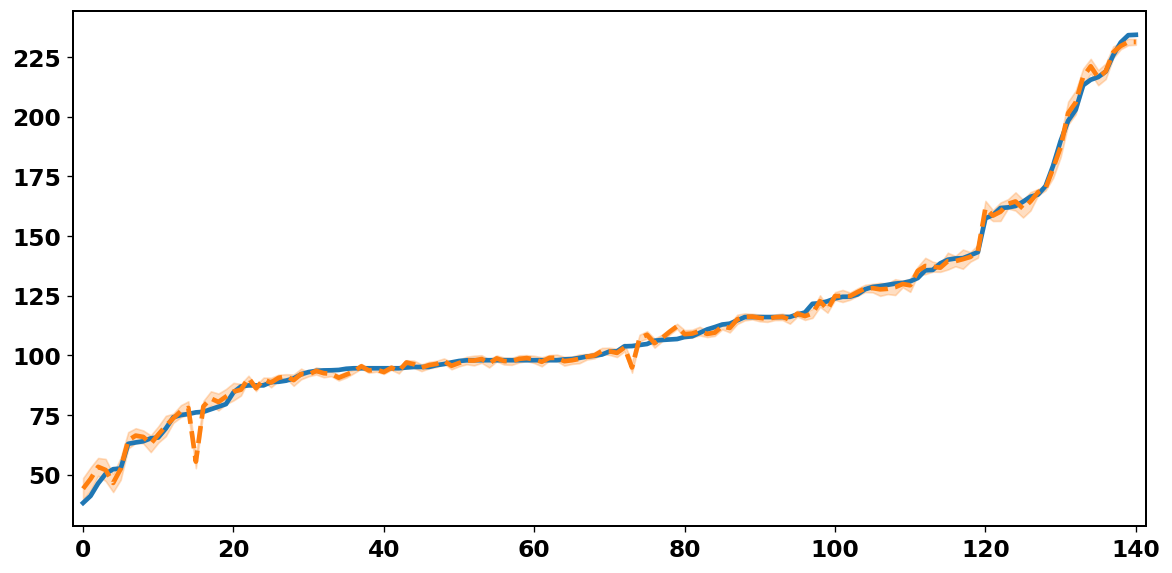

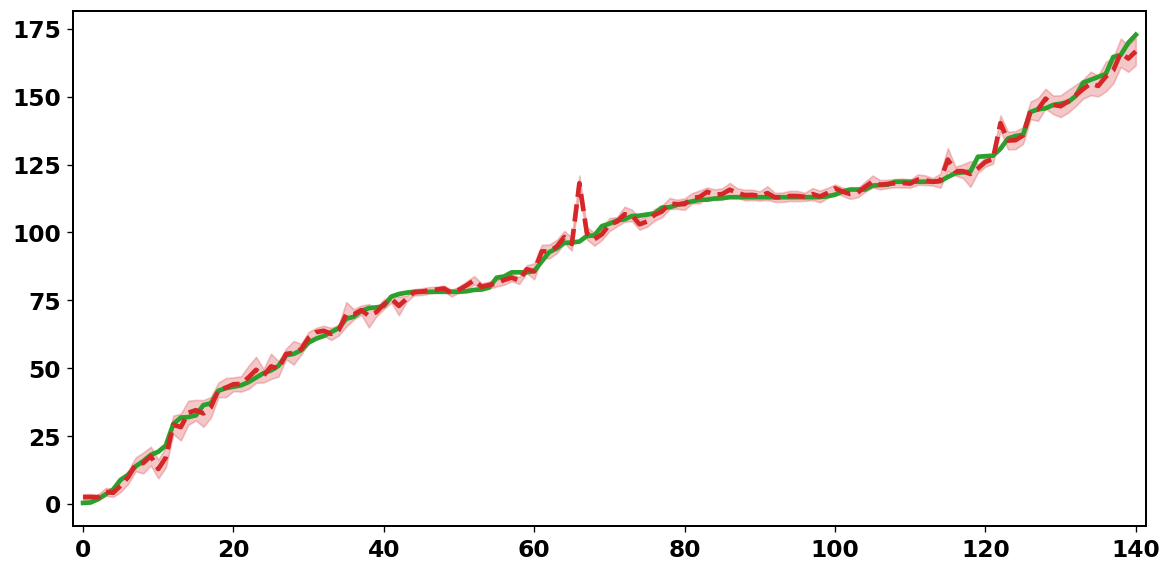

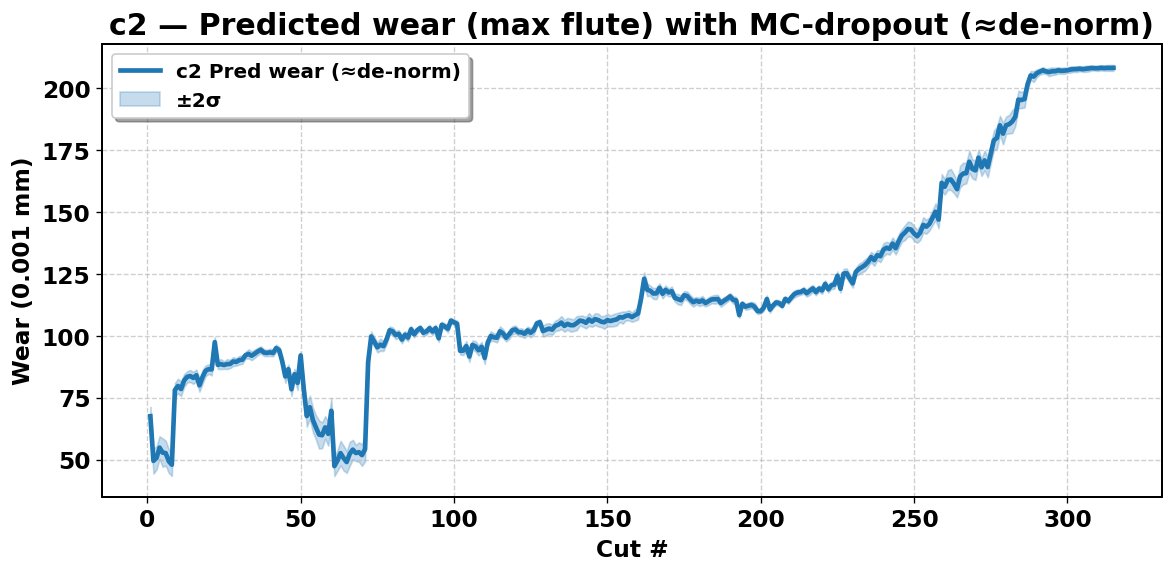

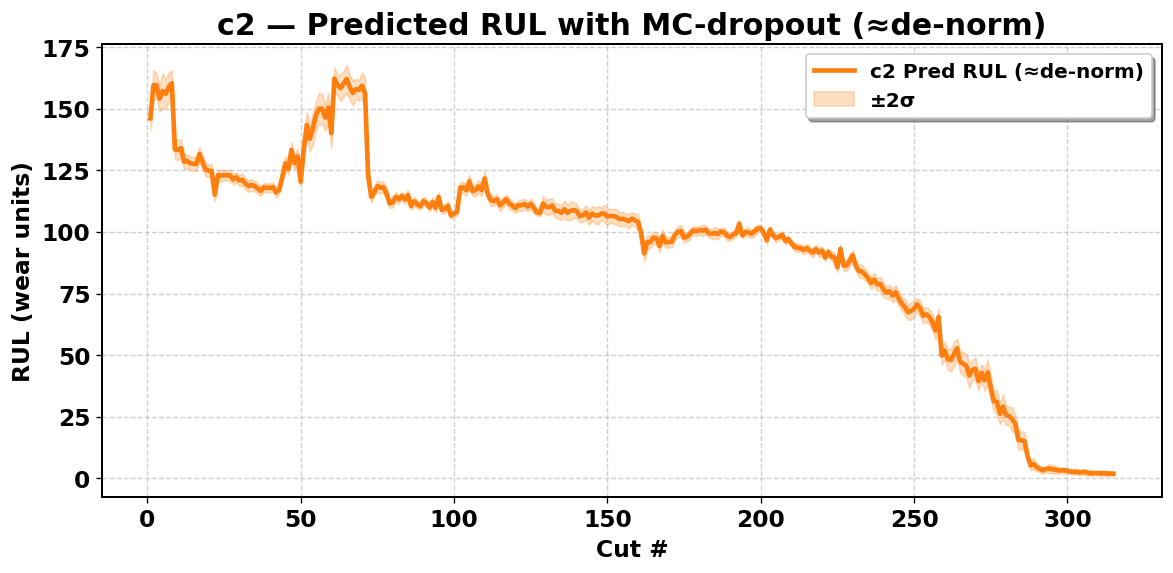

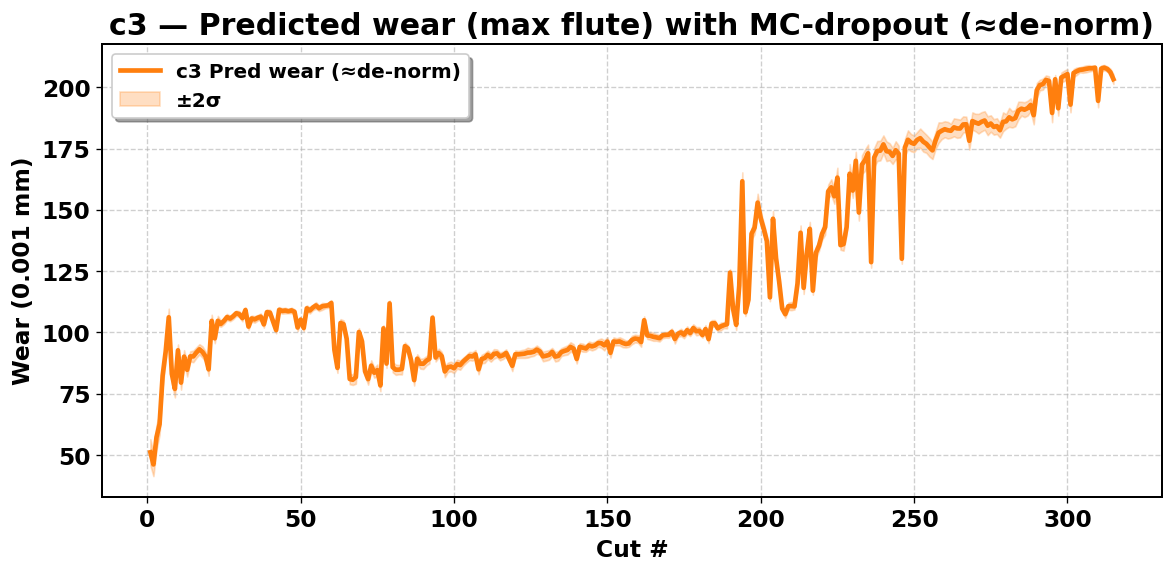

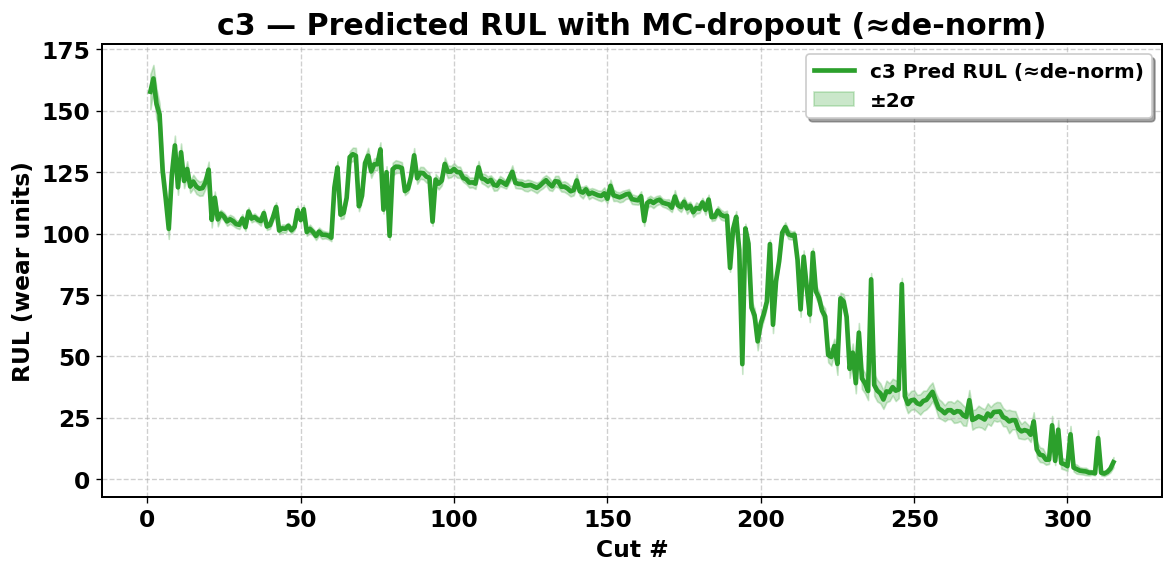

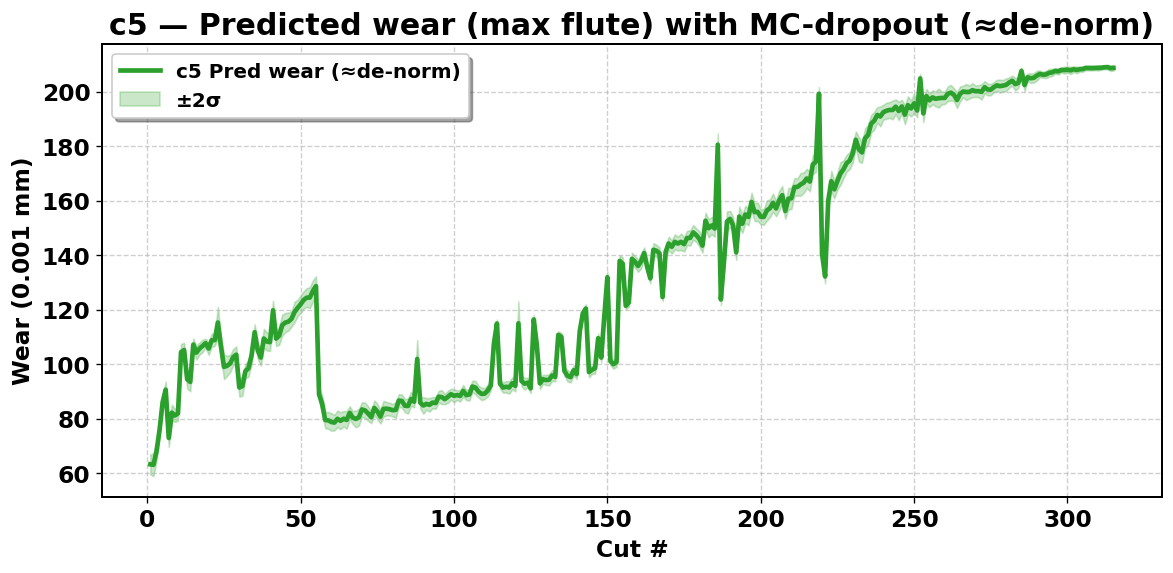

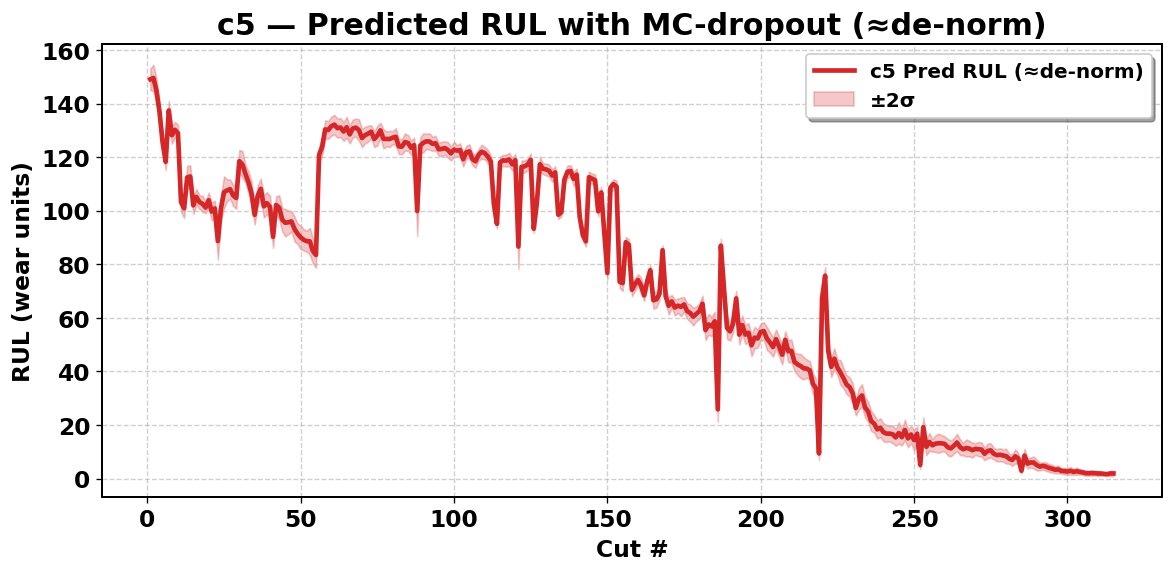

In [16]:
# ======= Build missing arrays via MC-dropout and plot =======
import numpy as np
import pandas as pd
import torch
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

# --------- Utilities ---------
@torch.no_grad()
def _mc_dropout_batch(model, X, L, T=50):
    """
    Run T stochastic forward passes with dropout ON.
    Returns tensors of shape [B, T] for wear_max_norm and rul_norm.
    """
    outs_w = []
    outs_r = []
    for _ in range(T):
        f1,f2,f3,wmax,rul = model(X, L)  # dropout active if model.train()
        outs_w.append(wmax.unsqueeze(1))  # [B,1]
        outs_r.append(rul.unsqueeze(1))   # [B,1]
    W = torch.cat(outs_w, dim=1)  # [B,T]
    R = torch.cat(outs_r, dim=1)  # [B,T]
    return W, R  # normalized (0..1)

def _enable_dropout(model):
    """
    Put the model in eval-like mode but keep Dropout active.
    In our network there are no BatchNorm layers, so we can safely use model.train()
    while using torch.no_grad() to avoid grads.
    """
    model.train()

def _to_np(x):
    return x.detach().cpu().numpy()

# --------- 1) VAL: MC-dropout means/stds and ground-truth (de-normalized) ---------
def mc_dropout_on_val(model, val_loader, device, T=50):
    _enable_dropout(model)
    Ys = []            # ground truth: [wear_raw, RUL_raw]
    W_means = []       # wear mean (raw units)
    W_stds  = []
    R_means = []       # RUL mean (raw units)
    R_stds  = []

    with torch.no_grad():
        for X,L,Xp,Lp,yn,yr,eol,cutn,cutter in tqdm(val_loader, desc=f"MC-dropout (val,T={T})"):
            X = X.to(device); L = torch.clamp(L.to(device), min=1)
            eol = eol.to(device)

            Wnorm, Rnorm = _mc_dropout_batch(model, X, L, T=T)  # [B,T] normalized
            # de-normalize per-sample using their EOL
            # Expand EOL to [B, T]
            eol_exp = eol.unsqueeze(1).expand_as(Wnorm)
            W_raw = Wnorm * eol_exp
            R_raw = Rnorm * eol_exp

            W_means.append(_to_np(W_raw.mean(dim=1)))
            W_stds.append(_to_np(W_raw.std(dim=1, unbiased=False)))
            R_means.append(_to_np(R_raw.mean(dim=1)))
            R_stds.append(_to_np(R_raw.std(dim=1, unbiased=False)))

            # ground-truth wear/RUL raw are at yr[:,3] and yr[:,4]
            Ys.append(yr[:,3:5].cpu().numpy())

    Yv = np.vstack(Ys)                      # [N,2] -> [:,0]=wear_raw, [:,1]=RUL_raw
    Wm_v = np.concatenate(W_means, axis=0)  # [N]
    Ws_v = np.concatenate(W_stds,  axis=0)  # [N]
    Rm_v = np.concatenate(R_means, axis=0)  # [N]
    Rs_v = np.concatenate(R_stds,  axis=0)  # [N]
    return Yv, Wm_v, Ws_v, Rm_v, Rs_v

# --------- 2) TEST: approximate MC-dropout using EOL_REF (no labels) ---------
def mc_dropout_on_test(model, test_loader, device, EOL_REF, T=50):
    _enable_dropout(model)
    rows = []
    with torch.no_grad():
        for X,L,Xp,Lp,yn,yr,eol,cutn,cutter in tqdm(test_loader, desc=f"MC-dropout (test,T={T})"):
            X = X.to(device); L = torch.clamp(L.to(device), min=1)

            Wnorm, Rnorm = _mc_dropout_batch(model, X, L, T=T)  # [B,T] normalized
            # Use median training EOL for approximate de-normalization
            scale = torch.full_like(Wnorm, float(EOL_REF))
            W_raw = Wnorm * scale
            R_raw = Rnorm * scale

            mu_w = _to_np(W_raw.mean(dim=1)); sd_w = _to_np(W_raw.std(dim=1, unbiased=False))
            mu_r = _to_np(R_raw.mean(dim=1)); sd_r = _to_np(R_raw.std(dim=1, unbiased=False))

            # gather metadata from collate (numpy arrays of shape [B])
            cutn_np = np.array(cutn, dtype=int)
            cutter_np = np.array(cutter)

            for i in range(len(cutn_np)):
                rows.append({
                    "cutter": cutter_np[i],
                    "cut_number": int(cutn_np[i]),
                    "wear_approx": float(mu_w[i]),
                    "wear_approx_std": float(sd_w[i]),
                    "rul_approx": float(mu_r[i]),
                    "rul_approx_std": float(sd_r[i]),
                })
    pred_df = pd.DataFrame(rows).sort_values(["cutter","cut_number"]).reset_index(drop=True)
    return pred_df

# --------- Run both passes ---------
T_DROPOUT = 50  # you can lower to 20 for speed

# Ensure model on correct device
model.to(device)

Yv, Wm_v, Ws_v, Rm_v, Rs_v = mc_dropout_on_val(model, val_loader, device, T=T_DROPOUT)
print("Validation arrays ready:",
      f"Yv {Yv.shape}, Wm_v {Wm_v.shape}, Ws_v {Ws_v.shape}, Rm_v {Rm_v.shape}, Rs_v {Rs_v.shape}")

pred_df = mc_dropout_on_test(model, test_loader, device, EOL_REF=EOL_REF, T=T_DROPOUT)
print("Test pred_df rows:", len(pred_df))

# --------- (Optional) Trigger your existing plotting cell now ---------
try:
    # Wear (val)
    mask_w = np.isfinite(Yv[:, 0])
    if mask_w.any():
        order_w = np.argsort(Yv[:, 0][mask_w])
        xw = np.arange(order_w.size)
        y_true_w = Yv[:, 0][mask_w][order_w]
        y_pred_w = Wm_v[mask_w][order_w]
        y_std_w  = Ws_v[mask_w][order_w]
        plot_truth_pred_band(
            x=xw, y_true=y_true_w, y_pred=y_pred_w, y_std=y_std_w,
            labels=("True wear", "Pred wear", "±2σ"),
            colors=["tab:blue", "tab:orange"],
        )
        plt.gca().set_title("Validation — Tool wear (max flute) with MC-dropout uncertainty")
        plt.gca().set_xlabel("Sample (sorted by truth)")
        plt.gca().set_ylabel("Wear (0.001 mm)")
        plt.gcf().savefig("val_wear_mc_dropout.png", bbox_inches="tight")
        plt.close()

    # RUL (val)
    mask_r = np.isfinite(Yv[:, 1])
    if mask_r.any():
        order_r = np.argsort(Yv[:, 1][mask_r])
        xr = np.arange(order_r.size)
        y_true_r = Yv[:, 1][mask_r][order_r]
        y_pred_r = Rm_v[mask_r][order_r]
        y_std_r  = Rs_v[mask_r][order_r]
        plot_truth_pred_band(
            x=xr, y_true=y_true_r, y_pred=y_pred_r, y_std=y_std_r,
            labels=("True RUL", "Pred RUL", "±2σ"),
            colors=["tab:green", "tab:red"],
        )
        plt.gca().set_title("Validation — RUL with MC-dropout uncertainty")
        plt.gca().set_xlabel("Sample (sorted by truth)")
        plt.gca().set_ylabel("RUL (wear units)")
        plt.gcf().savefig("val_rul_mc_dropout.png", bbox_inches="tight")
        plt.close()

    # TEST per-cutter (approx)
    for idx, cname in enumerate(TEST_CUTTERS):
        dd = pred_df[pred_df["cutter"] == cname]
        if dd.empty: 
            continue
        x = dd["cut_number"].values

        # Wear approx
        mu_w = dd["wear_approx"].values
        sd_w = dd["wear_approx_std"].values
        color_w = COLOR_CYCLE[idx % len(COLOR_CYCLE)]
        plot_pred_band_only(
            x=x, y_pred=mu_w, y_std=sd_w,
            label_pred=f"{cname} Pred wear (≈de-norm)",
            band_label="±2σ", color=color_w,
            title=f"{cname} — Predicted wear (max flute) with MC-dropout (≈de-norm)",
            xlabel="Cut #", ylabel="Wear (0.001 mm)",
            fname=f"test_{cname}_wear_mc_dropout.png",
        )

        # RUL approx
        mu_r = dd["rul_approx"].values
        sd_r = dd["rul_approx_std"].values
        color_r = COLOR_CYCLE[(idx+1) % len(COLOR_CYCLE)]
        plot_pred_band_only(
            x=x, y_pred=mu_r, y_std=sd_r,
            label_pred=f"{cname} Pred RUL (≈de-norm)",
            band_label="±2σ", color=color_r,
            title=f"{cname} — Predicted RUL with MC-dropout (≈de-norm)",
            xlabel="Cut #", ylabel="RUL (wear units)",
            fname=f"test_{cname}_rul_mc_dropout.png",
        )
except Exception as e:
    print(f"[info] Plotting skipped due to: {e}")
